In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(
    '../../data/SPY_5y_daily.csv',
    header=[0, 1],
    index_col=0,
    parse_dates=True
    )

data.columns = data.columns.droplevel(1)
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2021-01-19,353.460846,354.002278,351.687246,353.171471,51233300
2021-01-20,358.352234,359.192357,355.365098,355.757142,61836100
2021-01-21,358.678955,359.341744,357.754823,358.912324,47840100
2021-01-22,357.409393,358.576239,356.438570,356.821299,52860500
2021-01-25,358.819000,359.173697,353.283464,358.146896,70402000


In [3]:
df = data[['Close']].copy()
df['Return'] = data['Close'].pct_change()
df.dropna(inplace=True)
df.head()

Price,Close,Return
Date,,
2021-01-20,358.352234,0.013839
2021-01-21,358.678955,0.000912
2021-01-22,357.409393,-0.003540
2021-01-25,358.819000,0.003944
2021-01-26,358.258881,-0.001561


In [4]:
initial_capital = 100_000
# __________Bu trade yokken “buy & hold” ne olur görmek için _____________
df['equity_passive'] = initial_capital * (1 + df['Return']).cumprod()
df.head()

Price,Close,Return,equity_passive
Date,,,
2021-01-20,358.352234,0.013839,101383.855665
2021-01-21,358.678955,0.000912,101476.290568
2021-01-22,357.409393,-0.003540,101117.110257
2021-01-25,358.819000,0.003944,101515.911694
2021-01-26,358.258881,-0.001561,101357.444459


In [5]:
in_position = False
entry_price = None
entry_date = None

equity = initial_capital
equity_curve = []

trades = []

In [6]:
for i in range(1, len(df)):
    today = df.iloc[i]
    yesterday = df.iloc[i - 1]

    if not in_position:

        if today['Close'] > yesterday['Close']:
            in_position = True
            entry_price = today['Close']
            entry_date = today.name
    else:

        if today['Close'] < yesterday['Close']:
            exit_price = today['Close']
            exit_date = today.name

            trade_return = (exit_price - entry_price) / entry_price
            equity *= (1 + trade_return)

            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'trade_return': trade_return
            })


            in_position = False
            entry_price = None
            entry_date = None
            
    equity_curve.append(equity)

In [7]:
tradeDF = pd.DataFrame(trades)
tradeDF.head()

,entry_date,exit_date,entry_price,exit_price,trade_return
0,2021-01-21,2021-01-22,358.678955,357.409393,-0.003540
1,2021-01-25,2021-01-26,358.819000,358.258881,-0.001561
2,2021-01-28,2021-01-29,352.508667,345.451569,-0.020020
3,2021-02-01,2021-02-09,351.201782,364.289093,0.037264
4,2021-02-11,2021-02-16,364.718536,366.202728,0.004069


In [8]:
tradeDF['is_win'] = tradeDF['trade_return'] > 0

In [9]:
win_rate = tradeDF['is_win'].mean()
win_loss_ratio = tradeDF['is_win'].sum() / (~tradeDF['is_win']).sum()

win_rate, win_loss_ratio

(np.float64(0.40129449838187703), np.float64(0.6702702702702703))

In [10]:
loss_streak = 0
max_loss_streak = 0

for win in tradeDF['is_win']:
    if not win:
        loss_streak += 1
        max_loss_streak = max(loss_streak, max_loss_streak)
    else:
        loss_streak = 0

max_loss_streak

13

In [11]:
gross_profit = tradeDF.loc[tradeDF['trade_return'] > 0, 'trade_return'].sum()
gross_loss = tradeDF.loc[tradeDF['trade_return'] < 0, 'trade_return'].sum()

profit_factor = gross_profit / abs(gross_loss)
profit_factor

np.float64(1.180321825406334)

In [12]:
equity_series = pd.Series(equity_curve)

rolling_max = equity_series.cummax()
drawdown = (equity_series - rolling_max) / rolling_max
max_drawdown = drawdown.min()

max_drawdown

np.float64(-0.18887444492035604)

In [13]:
total_return = (equity_series.iloc[-1] / initial_capital) - 1
total_return

np.float64(0.2560108178534106)

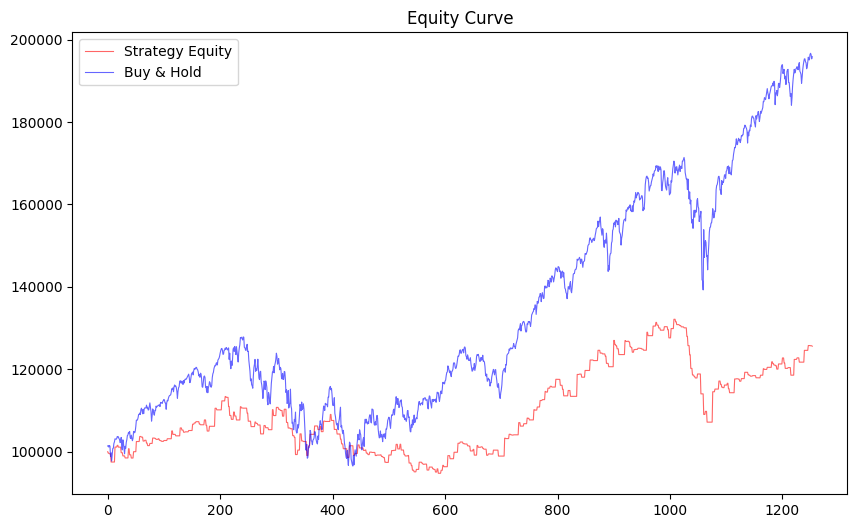

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(equity_series, label='Strategy Equity', color='red', linewidth=0.8, alpha=0.6)
plt.plot(df['equity_passive'].values[:len(equity_series)], label='Buy & Hold', alpha=0.6, color='blue', linewidth=0.8)

plt.title('Equity Curve')
plt.legend()
plt.show()

In [15]:
print(f"Total trades: {len(tradeDF)}")
print(f"Win rate: {win_rate:.2%}")
print(f"Win/Loss ratio: {win_loss_ratio:.2f}")
print(f"Profit factor: {profit_factor:.2f}")
print(f"Total return: {total_return:.2%}")
print(f"Max drawdown: {max_drawdown:.2%}")
print(f"Worst loss streak: {max_loss_streak}")


Total trades: 309
Win rate: 40.13%
Win/Loss ratio: 0.67
Profit factor: 1.18
Total return: 25.60%
Max drawdown: -18.89%
Worst loss streak: 13


In [16]:
df.head()

Price,Close,Return,equity_passive
Date,,,
2021-01-20,358.352234,0.013839,101383.855665
2021-01-21,358.678955,0.000912,101476.290568
2021-01-22,357.409393,-0.003540,101117.110257
2021-01-25,358.819000,0.003944,101515.911694
2021-01-26,358.258881,-0.001561,101357.444459


In [17]:
df['MA50'] = (df['Close']).rolling(window=50).mean()
df['MA200'] = (df['Close']).rolling(window=200).mean()
df['Signal'] = (df['MA50'] > df['MA200'])

In [18]:
df.head()

Price,Close,Return,equity_passive,MA50,MA200,Signal
Date,,,,,,
2021-01-20,358.352234,0.013839,101383.855665,NaN,NaN,False
2021-01-21,358.678955,0.000912,101476.290568,NaN,NaN,False
2021-01-22,357.409393,-0.003540,101117.110257,NaN,NaN,False
2021-01-25,358.819000,0.003944,101515.911694,NaN,NaN,False
2021-01-26,358.258881,-0.001561,101357.444459,NaN,NaN,False


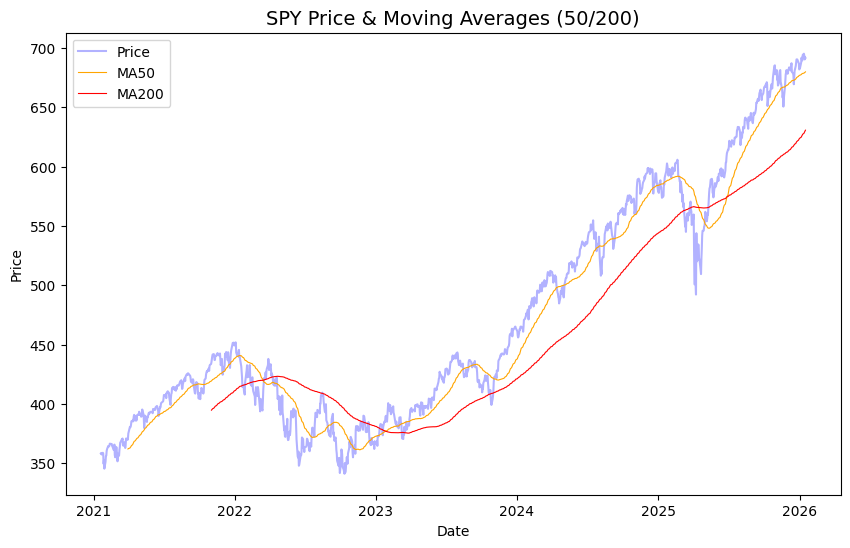

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(df['Close'], label='Price', color='blue', alpha=0.3)
plt.plot(df['MA50'], label='MA50', color='orange', linewidth=0.8)
plt.plot(df['MA200'], label='MA200', color='red', linewidth=0.8)

plt.title('SPY Price & Moving Averages (50/200)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

In [20]:
df['Close'].size

1255

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
data = pd.read_csv(
    '../../data/SPY_5y_daily.csv',
    header=[0, 1],
    index_col=0,
    parse_dates=True
    )

data.columns = data.columns.droplevel(1)
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2021-01-19,353.460846,354.002278,351.687246,353.171471,51233300
2021-01-20,358.352234,359.192357,355.365098,355.757142,61836100
2021-01-21,358.678955,359.341744,357.754823,358.912324,47840100
2021-01-22,357.409393,358.576239,356.438570,356.821299,52860500
2021-01-25,358.819000,359.173697,353.283464,358.146896,70402000


In [23]:
df = data[['Close']].copy()
df['Open'] = data['Open'].copy()

df.head(3)

Price,Close,Open
Date,,
2021-01-19,353.460846,353.171471
2021-01-20,358.352234,355.757142
2021-01-21,358.678955,358.912324


In [24]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

In [25]:
df['Signal'] = 0
df.loc[df['MA50'] > df['MA200'], 'Signal'] = 1

df['Signal'] = df['Signal'].shift(1)
df.dropna(inplace=True)

df.head(3)

Price,Close,Open,MA50,MA200,Signal
Date,,,,,
2021-11-01,433.637268,433.882327,419.130942,394.350059,0.0
2021-11-02,435.390564,433.806990,419.433865,394.759707,1.0
2021-11-03,438.048706,434.824975,419.776609,395.158190,1.0


In [26]:
initial_capital = 100_000
equity = initial_capital
commission_rate = 0.001
position = 0
equity_curve = [initial_capital]
trades = []


Total Return: 42.89%
Sharpe Ratio: 0.69
Total Trades: 2


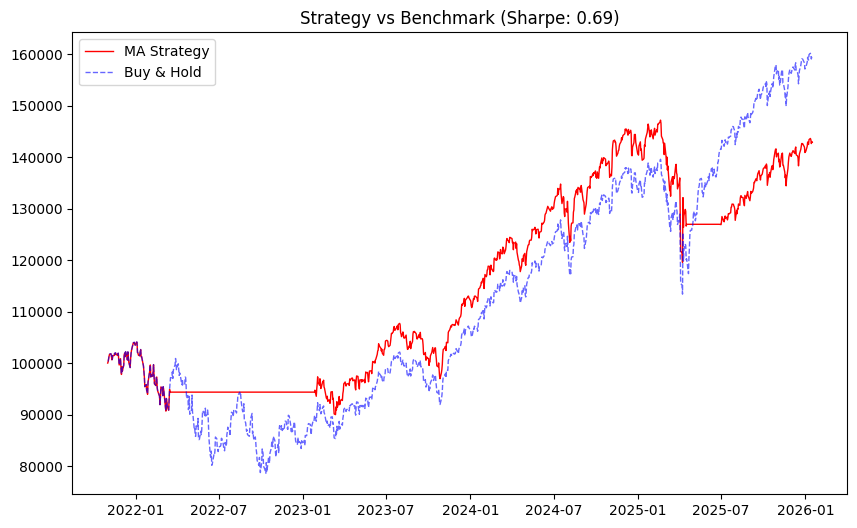

In [27]:
for i in range(len(df)):
    today = df.iloc[i]
    price = today['Open']
    signal = today['Signal']
    date = today.name

    if position == 0 and signal == 1:
        shares = (equity * (1 - commission_rate)) / price
        position = shares
        entry_price = today['Open']
        entry_date = date

    elif position > 0 and signal == 0:
        exit_price = price
        equity = position * exit_price * (1 - commission_rate)

        trade_return = (exit_price - entry_price) / entry_price
        trades.append(trade_return)

        position = 0

    if position > 0:
        current_equity = position * today['Close']
    else:
        current_equity = equity
    equity_curve.append(current_equity)

equity_curve = equity_curve[1:]
df['Strategy_Equity'] = equity_curve
df['BuyHold_Equity'] = (initial_capital * (1 - commission_rate)) * (1 + df['Close'].pct_change()).cumprod()

strategy_returns = df['Strategy_Equity'].pct_change()
sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)

total_return = (df['Strategy_Equity'].iloc[-1] / initial_capital) - 1

print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Total Trades: {len(trades)}")

plt.figure(figsize=(10, 6))
plt.plot(df['Strategy_Equity'], label ='MA Strategy', color='red', linewidth=1)
plt.plot(df['BuyHold_Equity'], label='Buy & Hold', color='blue', alpha=0.6, linestyle='--', linewidth=1)
plt.title(f'Strategy vs Benchmark (Sharpe: {sharpe_ratio:.2f})')
plt.legend()
plt.show()
